<h1>Big Mart Sales Prediction - Exploratory Data Analysis</h1>

In [2]:
!pip install duckdb

In [3]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import duckdb

In [4]:
from sklearn.feature_selection import chi2, RFE

<h3>Loading the Data</h3>

In [5]:
# Loading the dataset into the notebook
data = duckdb.sql('SELECT * FROM read_csv_auto("../data/used_device_data.csv")').df()
#duckdb.sql('SELECT * FROM data')

data

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3449,Asus,Android,15.34,yes,no,NaN,8.0,64.0,6.0,5000.0,190.0,2019,232,4.492337,6.483872
3450,Asus,Android,15.24,yes,no,13.0,8.0,128.0,8.0,4000.0,200.0,2018,541,5.037732,6.251538
3451,Alcatel,Android,15.80,yes,no,13.0,5.0,32.0,3.0,4000.0,165.0,2020,201,4.357350,4.528829
3452,Alcatel,Android,15.80,yes,no,13.0,5.0,32.0,2.0,4000.0,160.0,2020,149,4.349762,4.624188


<h3>Data Cleaning</h3>

In [6]:
# Storing data in variable df
df = duckdb.sql('select * from data').df()

In [7]:
# The number of columns and rows of the data
df.shape

(3454, 15)

In [8]:
# A look at the data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_brand           3454 non-null   object 
 1   os                     3454 non-null   object 
 2   screen_size            3454 non-null   float64
 3   4g                     3454 non-null   object 
 4   5g                     3454 non-null   object 
 5   rear_camera_mp         3275 non-null   float64
 6   front_camera_mp        3452 non-null   float64
 7   internal_memory        3450 non-null   float64
 8   ram                    3450 non-null   float64
 9   battery                3448 non-null   float64
 10  weight                 3447 non-null   float64
 11  release_year           3454 non-null   int64  
 12  days_used              3454 non-null   int64  
 13  normalized_used_price  3454 non-null   float64
 14  normalized_new_price   3454 non-null   float64
dtypes: f

As can be seen above, there are very few missing values in the dataset. There are also a few categorical/binary variables of type object. Since this project will likely use a few regression models, these may have to be encoded as numerical variables.

In [9]:
# A look at the unique values and counts for device_brand
duckdb.sql('select device_brand, COUNT(*) AS COUNTS FROM df GROUP BY device_brand ORDER BY COUNTS desc')

┌──────────────┬────────┐
│ device_brand │ COUNTS │
│   varchar    │ int64  │
├──────────────┼────────┤
│ Others       │    502 │
│ Samsung      │    341 │
│ Huawei       │    251 │
│ LG           │    201 │
│ Lenovo       │    171 │
│ ZTE          │    140 │
│ Xiaomi       │    132 │
│ Oppo         │    129 │
│ Asus         │    122 │
│ Alcatel      │    121 │
│  ·           │      · │
│  ·           │      · │
│  ·           │      · │
│ Lava         │     36 │
│ Celkon       │     33 │
│ Spice        │     30 │
│ Karbonn      │     29 │
│ OnePlus      │     22 │
│ Coolpad      │     22 │
│ BlackBerry   │     22 │
│ Microsoft    │     22 │
│ Google       │     15 │
│ Infinix      │     10 │
├──────────────┴────────┤
│  34 rows (20 shown)   │
└───────────────────────┘

There are 34 different categories and the one with the lowest count is 10.

In [10]:
# A look at the unique values and counts for os
duckdb.sql('select os, COUNT(*) FROM df GROUP BY os ')

┌─────────┬──────────────┐
│   os    │ count_star() │
│ varchar │    int64     │
├─────────┼──────────────┤
│ Android │         3214 │
│ Others  │          137 │
│ iOS     │           36 │
│ Windows │           67 │
└─────────┴──────────────┘

In [11]:
# A look at the unique values and counts for 4g
duckdb.sql('select "4g", COUNT(*) FROM df GROUP BY "4g"')

┌─────────┬──────────────┐
│   4g    │ count_star() │
│ varchar │    int64     │
├─────────┼──────────────┤
│ yes     │         2335 │
│ no      │         1119 │
└─────────┴──────────────┘

In [12]:
#Replacing yes and no with 1 and 0 respectively
df['4g'].replace({'yes':1, 'no':0}, inplace=True)
df['4g']

0       1
1       1
2       1
3       1
4       1
       ..
3449    1
3450    1
3451    1
3452    1
3453    1
Name: 4g, Length: 3454, dtype: int64

In [13]:
# A look at the unique values and counts for 5g
duckdb.sql('select "5g", COUNT(*) FROM df GROUP BY "5g"')

┌─────────┬──────────────┐
│   5g    │ count_star() │
│ varchar │    int64     │
├─────────┼──────────────┤
│ no      │         3302 │
│ yes     │          152 │
└─────────┴──────────────┘

In [14]:
#Replacing yes and no with 1 and 0 respectively
df['5g'].replace({'yes':1, 'no':0}, inplace=True)
df['5g']

0       0
1       1
2       1
3       1
4       0
       ..
3449    0
3450    0
3451    0
3452    0
3453    0
Name: 5g, Length: 3454, dtype: int64

In [19]:
duckdb.sql('select "days_used", COUNT(*) FROM df GROUP BY "days_used"')

┌───────────┬──────────────┐
│ days_used │ count_star() │
│   int64   │    int64     │
├───────────┼──────────────┤
│       127 │            3 │
│       325 │            5 │
│       162 │            2 │
│       345 │            1 │
│       293 │            5 │
│       223 │            4 │
│       234 │            5 │
│       219 │            3 │
│       161 │            2 │
│       327 │            2 │
│        ·  │            · │
│        ·  │            · │
│        ·  │            · │
│       481 │            2 │
│       367 │            1 │
│       685 │            3 │
│       837 │            1 │
│       744 │            3 │
│       598 │            4 │
│       620 │            4 │
│       982 │            2 │
│       168 │            1 │
│       907 │            1 │
├───────────┴──────────────┤
│   924 rows (20 shown)    │
└──────────────────────────┘

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_brand           3454 non-null   object 
 1   os                     3454 non-null   object 
 2   screen_size            3454 non-null   float64
 3   4g                     3454 non-null   int64  
 4   5g                     3454 non-null   int64  
 5   rear_camera_mp         3275 non-null   float64
 6   front_camera_mp        3452 non-null   float64
 7   internal_memory        3450 non-null   float64
 8   ram                    3450 non-null   float64
 9   battery                3448 non-null   float64
 10  weight                 3447 non-null   float64
 11  release_year           3454 non-null   int64  
 12  days_used              3454 non-null   int64  
 13  normalized_used_price  3454 non-null   float64
 14  normalized_new_price   3454 non-null   float64
dtypes: f

In [14]:
# Showing number of missing 'rear_camera_mp' per device brand.
frame = df.groupby('device_brand')[['rear_camera_mp', 'os']].count().sort_values(by='rear_camera_mp')
frame['missing'] = frame['os']-frame['rear_camera_mp']
frame=frame.sort_values(by='missing', ascending=False)
frame

,rear_camera_mp,os,missing
device_brand,,,
Realme,5,41,36
Xiaomi,109,132,23
Oppo,109,129,20
Motorola,88,106,18
OnePlus,5,22,17
Meizu,47,62,15
Vivo,103,117,14
Infinix,0,10,10
Sony,79,86,7


C:\Users\ituser\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Top 10 Devices with Missing value for Rear Camera mp')]

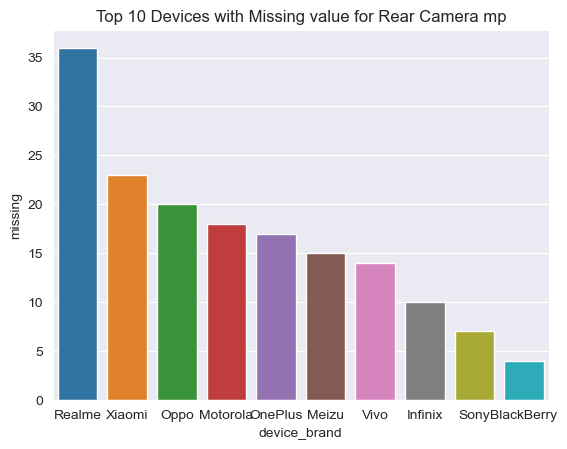

In [15]:
# Top 10 Devices with missing value for rear camera mp
sns.barplot(frame.index[0:10],frame['missing'][0:10]).set(title='Top 10 Devices with Missing value for Rear Camera mp')

In [16]:
# Correlation of rear camera mp to the target nomalized used price
corr_df = df[df['rear_camera_mp'].isna()==False]
corr_df['rear_camera_mp'].corr(corr_df['normalized_used_price'])

0.5873019744600587

correlation between rear_camera_mp and the target variable 'normalized_used_price' is quite high at 0.59. It is important that it is handled carefully. The decision will be made farther along in the project.

<AxesSubplot:>

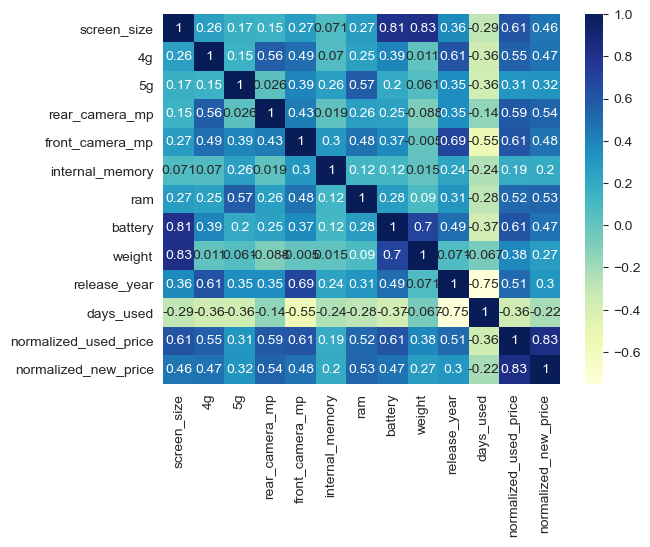

In [17]:
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_brand           3454 non-null   object 
 1   os                     3454 non-null   object 
 2   screen_size            3454 non-null   float64
 3   4g                     3454 non-null   int64  
 4   5g                     3454 non-null   int64  
 5   rear_camera_mp         3275 non-null   float64
 6   front_camera_mp        3452 non-null   float64
 7   internal_memory        3450 non-null   float64
 8   ram                    3450 non-null   float64
 9   battery                3448 non-null   float64
 10  weight                 3447 non-null   float64
 11  release_year           3454 non-null   int64  
 12  days_used              3454 non-null   int64  
 13  normalized_used_price  3454 non-null   float64
 14  normalized_new_price   3454 non-null   float64
dtypes: f

In [19]:
#showing devices with null for 'front_camera_mp'
#df[df['front_camera_mp'].isna()]

duckdb.sql('Select device_brand, os, release_year, rear_camera_mp, front_camera_mp FROM df WHERE "front_camera_mp" IS NULL')

┌──────────────┬─────────┬──────────────┬────────────────┬─────────────────┐
│ device_brand │   os    │ release_year │ rear_camera_mp │ front_camera_mp │
│   varchar    │ varchar │    int64     │     double     │     double      │
├──────────────┼─────────┼──────────────┼────────────────┼─────────────────┤
│ Google       │ Android │         2018 │           12.2 │            NULL │
│ Google       │ Android │         2018 │           12.2 │            NULL │
└──────────────┴─────────┴──────────────┴────────────────┴─────────────────┘

<AxesSubplot:>

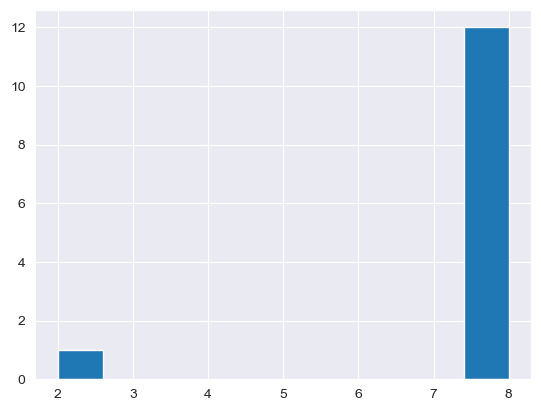

In [20]:
# histogram of google devices' front_camera_mp
df[df['device_brand'] == 'Google']['front_camera_mp'].hist()

Only 2 devices have missing front_camera_mp data. They are both Google devices. In addition, 12 out of 13 google devices with front_camera_mp data have the value 8. Based on this, we shall fill the missing 2 values with 8 as well.

In [21]:
# Filling missing 'front_camera_mp' with value 8.0 (the mode)
df['front_camera_mp'].fillna(8.0, inplace=True)

In [22]:
# Showing devices where 'internal_memory' is missing
#df[df['internal_memory'].isna()]
duckdb.sql('Select device_brand, os, release_year, internal_memory FROM df WHERE "internal_memory" IS NULL')

┌──────────────┬─────────┬──────────────┬─────────────────┐
│ device_brand │   os    │ release_year │ internal_memory │
│   varchar    │ varchar │    int64     │     double      │
├──────────────┼─────────┼──────────────┼─────────────────┤
│ Nokia        │ Others  │         2019 │            NULL │
│ Nokia        │ Others  │         2019 │            NULL │
│ Nokia        │ Others  │         2015 │            NULL │
│ Nokia        │ Others  │         2013 │            NULL │
└──────────────┴─────────┴──────────────┴─────────────────┘

In [23]:
# Showing all Nokia Devices
df[df['device_brand']=='Nokia']
#duckdb.sql('Select device_brand, os, release_year, internal_memory FROM df WHERE device_brand = Nokia')

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
110,Nokia,Android,16.56,1,0,0.3,8.0,64.00,3.00,4000.0,200.0,2020,310,4.186012,5.004885
111,Nokia,Android,13.84,1,0,0.3,5.0,16.00,2.00,3000.0,180.0,2020,193,3.616309,4.100161
112,Nokia,Android,13.84,1,0,0.3,5.0,16.00,2.00,3000.0,180.0,2020,356,4.055430,4.591984
113,Nokia,Others,5.18,0,0,0.3,0.0,0.10,0.03,1020.0,90.5,2020,272,2.910174,3.399863
114,Nokia,Others,5.18,0,0,0.3,0.0,0.06,NaN,1020.0,91.3,2020,288,2.729159,2.911263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3384,Nokia,Android,15.29,1,0,13.0,5.0,32.00,2.00,4000.0,183.0,2019,520,4.145671,4.438289
3385,Nokia,Android,15.32,1,0,5.0,20.0,64.00,4.00,3500.0,180.0,2019,459,4.789407,5.127292
3386,Nokia,Android,15.32,1,0,5.0,8.0,32.00,3.00,3500.0,180.0,2019,417,4.145354,4.950107
3387,Nokia,Others,5.28,1,0,2.0,0.0,0.10,0.03,1500.0,118.0,2019,295,3.444576,4.085304


There are 106 Nokia devices. Only 4 have missing internal memory data. These shall be deleted.

In [24]:
# Removing records where internal memory data is missing
df=df[df['internal_memory'].isna()==False]

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3450 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_brand           3450 non-null   object 
 1   os                     3450 non-null   object 
 2   screen_size            3450 non-null   float64
 3   4g                     3450 non-null   int64  
 4   5g                     3450 non-null   int64  
 5   rear_camera_mp         3271 non-null   float64
 6   front_camera_mp        3450 non-null   float64
 7   internal_memory        3450 non-null   float64
 8   ram                    3446 non-null   float64
 9   battery                3444 non-null   float64
 10  weight                 3443 non-null   float64
 11  release_year           3450 non-null   int64  
 12  days_used              3450 non-null   int64  
 13  normalized_used_price  3450 non-null   float64
 14  normalized_new_price   3450 non-null   float64
dtypes: f

In [26]:
# Showing records with missing RAM
#df[df['ram'].isna()]
duckdb.sql('Select device_brand, os, release_year, ram FROM df WHERE "ram" IS NULL')

┌──────────────┬─────────┬──────────────┬────────┐
│ device_brand │   os    │ release_year │  ram   │
│   varchar    │ varchar │    int64     │ double │
├──────────────┼─────────┼──────────────┼────────┤
│ Nokia        │ Others  │         2020 │   NULL │
│ Nokia        │ Others  │         2020 │   NULL │
│ Nokia        │ Others  │         2016 │   NULL │
│ Nokia        │ Others  │         2013 │   NULL │
└──────────────┴─────────┴──────────────┴────────┘

In [27]:
# Removing records where RAM is missing
df = df[df['ram'].isna()==False]

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3446 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_brand           3446 non-null   object 
 1   os                     3446 non-null   object 
 2   screen_size            3446 non-null   float64
 3   4g                     3446 non-null   int64  
 4   5g                     3446 non-null   int64  
 5   rear_camera_mp         3267 non-null   float64
 6   front_camera_mp        3446 non-null   float64
 7   internal_memory        3446 non-null   float64
 8   ram                    3446 non-null   float64
 9   battery                3441 non-null   float64
 10  weight                 3439 non-null   float64
 11  release_year           3446 non-null   int64  
 12  days_used              3446 non-null   int64  
 13  normalized_used_price  3446 non-null   float64
 14  normalized_new_price   3446 non-null   float64
dtypes: f

In [29]:
# Showing records where battery data is missing
#df[df['battery'].isna()]

duckdb.sql('Select device_brand, os, release_year, battery FROM df WHERE "battery" IS NULL')

┌──────────────┬─────────┬──────────────┬─────────┐
│ device_brand │   os    │ release_year │ battery │
│   varchar    │ varchar │    int64     │ double  │
├──────────────┼─────────┼──────────────┼─────────┤
│ Meizu        │ Android │         2014 │    NULL │
│ Meizu        │ Android │         2014 │    NULL │
│ Meizu        │ Android │         2014 │    NULL │
│ Microsoft    │ Windows │         2013 │    NULL │
│ Nokia        │ Others  │         2016 │    NULL │
└──────────────┴─────────┴──────────────┴─────────┘

In [30]:
# Deleting records where battery data is missing
df = df[df['battery'].isna()==False]

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3441 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_brand           3441 non-null   object 
 1   os                     3441 non-null   object 
 2   screen_size            3441 non-null   float64
 3   4g                     3441 non-null   int64  
 4   5g                     3441 non-null   int64  
 5   rear_camera_mp         3262 non-null   float64
 6   front_camera_mp        3441 non-null   float64
 7   internal_memory        3441 non-null   float64
 8   ram                    3441 non-null   float64
 9   battery                3441 non-null   float64
 10  weight                 3434 non-null   float64
 11  release_year           3441 non-null   int64  
 12  days_used              3441 non-null   int64  
 13  normalized_used_price  3441 non-null   float64
 14  normalized_new_price   3441 non-null   float64
dtypes: f

In [32]:
# showing records where wight data is missing
#df[df['weight'].isna()]

duckdb.sql('Select device_brand, os, release_year, weight FROM df WHERE "weight" IS NULL')

┌──────────────┬─────────┬──────────────┬────────┐
│ device_brand │   os    │ release_year │ weight │
│   varchar    │ varchar │    int64     │ double │
├──────────────┼─────────┼──────────────┼────────┤
│ XOLO         │ Android │         2015 │   NULL │
│ XOLO         │ Android │         2015 │   NULL │
│ XOLO         │ Android │         2015 │   NULL │
│ XOLO         │ Android │         2015 │   NULL │
│ XOLO         │ Android │         2015 │   NULL │
│ XOLO         │ Windows │         2015 │   NULL │
│ XOLO         │ Android │         2015 │   NULL │
└──────────────┴─────────┴──────────────┴────────┘

In [33]:
# Deleting recrods where weight data is missing
df = df[df['weight'].isna()==False]

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3434 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_brand           3434 non-null   object 
 1   os                     3434 non-null   object 
 2   screen_size            3434 non-null   float64
 3   4g                     3434 non-null   int64  
 4   5g                     3434 non-null   int64  
 5   rear_camera_mp         3255 non-null   float64
 6   front_camera_mp        3434 non-null   float64
 7   internal_memory        3434 non-null   float64
 8   ram                    3434 non-null   float64
 9   battery                3434 non-null   float64
 10  weight                 3434 non-null   float64
 11  release_year           3434 non-null   int64  
 12  days_used              3434 non-null   int64  
 13  normalized_used_price  3434 non-null   float64
 14  normalized_new_price   3434 non-null   float64
dtypes: f

In [36]:
179/3434

0.052125800815375656

At this point, only rear_camera_mp has missing records. There are about 179 records with missing values for this field out of 3434. This is about 5% of the records. Earlier, it was established that 34 brands of devices have missing rear_camera_mp data. There was no pattern that could be found for this missing values. A decision shall be taken to delete these 179 records for now, but it may be revised at a later stage.

In [37]:
# Deleting recrods where weight data is missing
df = df[df['rear_camera_mp'].isna()==False]

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3255 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_brand           3255 non-null   object 
 1   os                     3255 non-null   object 
 2   screen_size            3255 non-null   float64
 3   4g                     3255 non-null   int64  
 4   5g                     3255 non-null   int64  
 5   rear_camera_mp         3255 non-null   float64
 6   front_camera_mp        3255 non-null   float64
 7   internal_memory        3255 non-null   float64
 8   ram                    3255 non-null   float64
 9   battery                3255 non-null   float64
 10  weight                 3255 non-null   float64
 11  release_year           3255 non-null   int64  
 12  days_used              3255 non-null   int64  
 13  normalized_used_price  3255 non-null   float64
 14  normalized_new_price   3255 non-null   float64
dtypes: f

There are no more missing values from the dataset. The fields 'device_brand' and 'os' are still of object data type. This will be corrected as we approach the modelling stage.

In [39]:
df.describe()

,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
count,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000
mean,13.617757,0.660522,0.026114,9.478028,6.094962,52.105945,3.962983,3074.986943,182.483502,2015.767742,695.544086,4.342802,5.218530
std,3.850476,0.473605,0.159498,4.801198,6.597721,85.416490,1.225518,1296.576955,90.334064,2.187747,235.461637,0.579642,0.672706
min,5.080000,0.000000,0.000000,0.080000,0.000000,0.010000,0.020000,500.000000,69.000000,2013.000000,91.000000,1.536867,2.901422
25%,12.700000,0.000000,0.000000,5.000000,2.000000,16.000000,4.000000,2100.000000,140.475000,2014.000000,564.000000,4.019621,4.789157
50%,12.830000,1.000000,0.000000,8.000000,5.000000,32.000000,4.000000,3000.000000,158.000000,2015.000000,705.000000,4.377893,5.242329
75%,15.320000,1.000000,0.000000,13.000000,8.000000,64.000000,4.000000,3950.000000,182.000000,2018.000000,879.000000,4.726104,5.638123
max,30.710000,1.000000,1.000000,48.000000,32.000000,1024.000000,12.000000,9720.000000,855.000000,2020.000000,1094.000000,6.619433,7.847841


The average price is about 5.2 (normalized). A quick look at the distribution of the dataset:

array([[<AxesSubplot:title={'center':'screen_size'}>,
        <AxesSubplot:title={'center':'4g'}>,
        <AxesSubplot:title={'center':'5g'}>,
        <AxesSubplot:title={'center':'rear_camera_mp'}>],
       [<AxesSubplot:title={'center':'front_camera_mp'}>,
        <AxesSubplot:title={'center':'internal_memory'}>,
        <AxesSubplot:title={'center':'ram'}>,
        <AxesSubplot:title={'center':'battery'}>],
       [<AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'release_year'}>,
        <AxesSubplot:title={'center':'days_used'}>,
        <AxesSubplot:title={'center':'normalized_used_price'}>],
       [<AxesSubplot:title={'center':'normalized_new_price'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

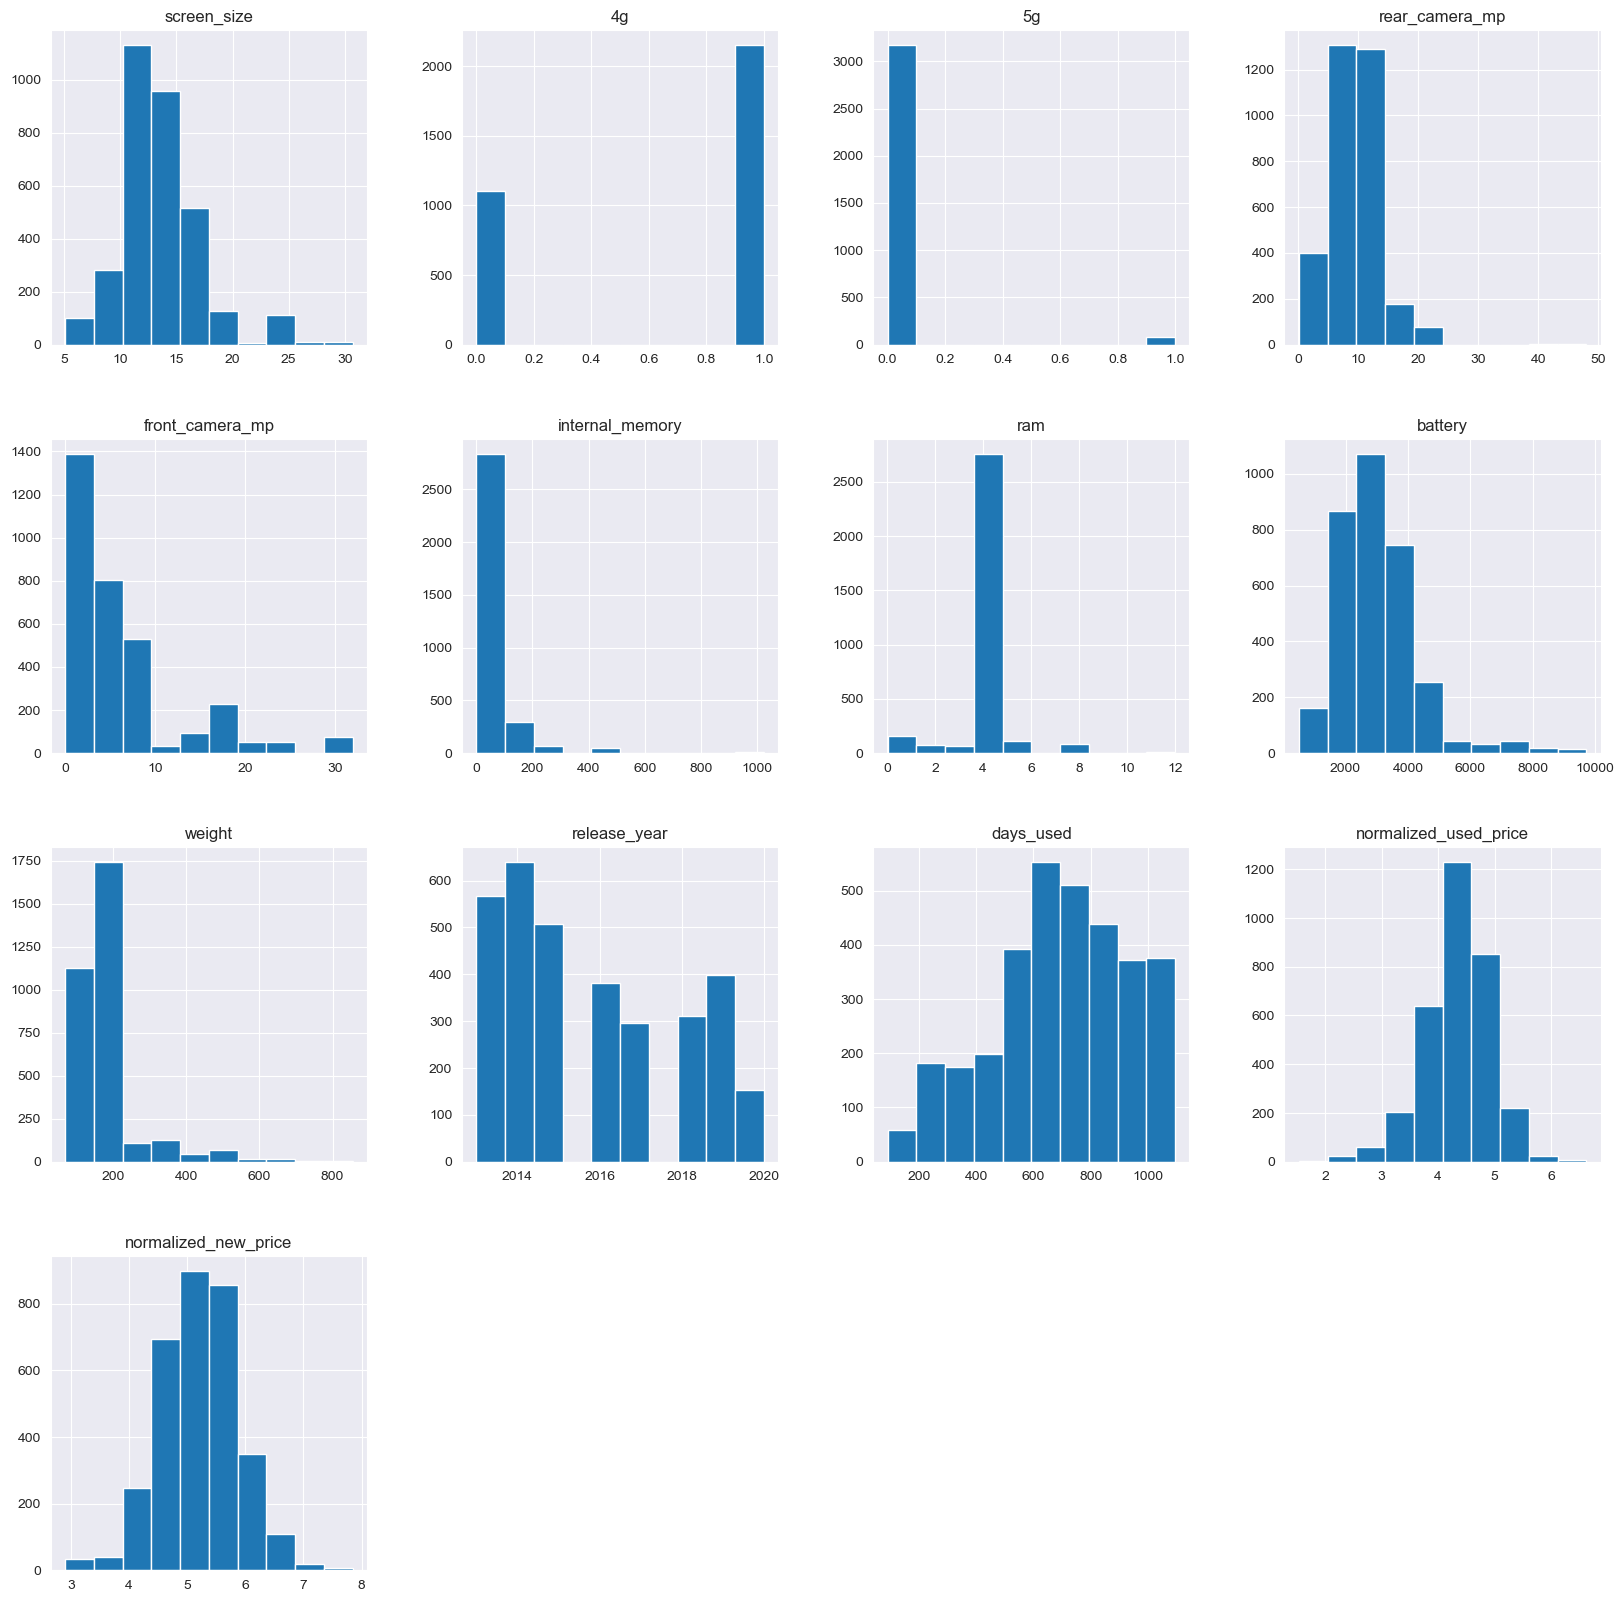

In [41]:
fields = df.columns
df.hist(figsize=(20,20))

Some of the fields look normally distributed while others don't. front_camera_mp, internal_memory, weight all seem like they could go closer to normal distribution through the use of log function. We could also explore what to do with release_year and days_used.

<AxesSubplot:>

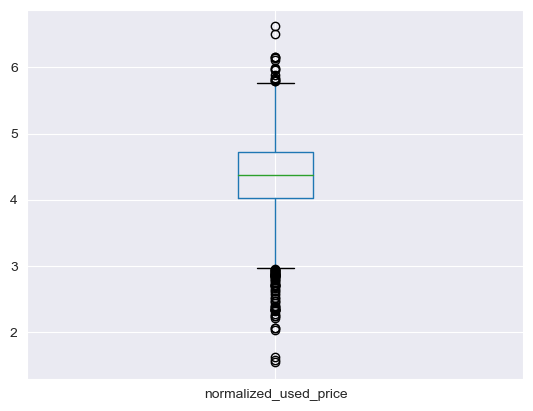

In [60]:
df[['normalized_used_price']].boxplot()

<AxesSubplot:>

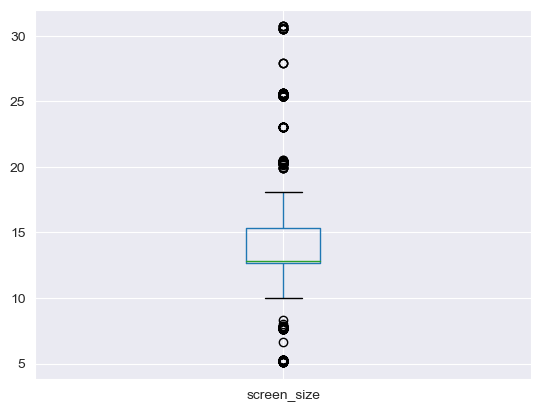

In [47]:
df[['screen_size']].boxplot()

<AxesSubplot:>

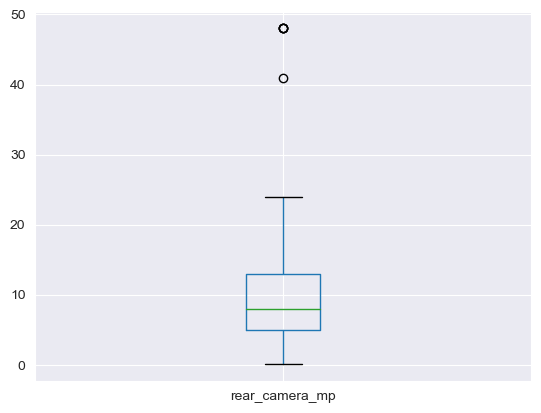

In [49]:
df[['rear_camera_mp']].boxplot()

<AxesSubplot:>

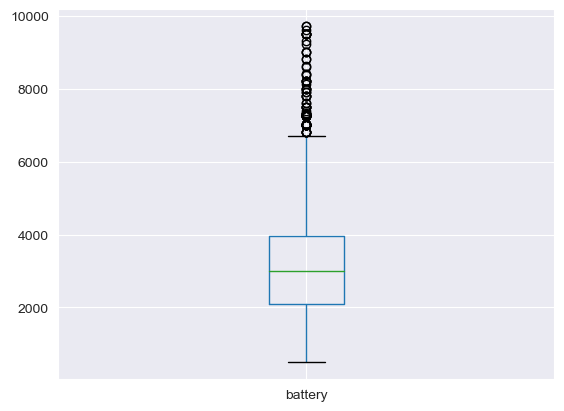

In [50]:
df[['battery']].boxplot()

<AxesSubplot:>

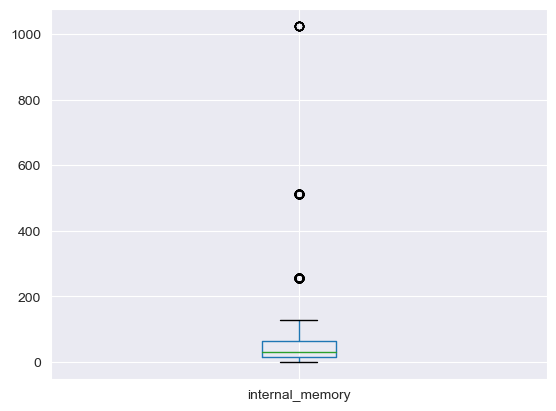

In [51]:
df[['internal_memory']].boxplot()

As can be seen in the box plots above, the fields with distribution closer to normal tend to have fewer outliers or less extreme outliers.

Since the target variable and used price are both already normalized, the distribution for both fields is already quite normal.

<h3>Multivariate Analysis</h3>

In this section, we look to see correlation between the various fields with the target variable 'normalized_new_price'.

In [58]:
# Resale value for each brand
df.groupby('device_brand').mean('normalized_used_price')['normalized_used_price'].sort_values(ascending=False)

device_brand
Apple         5.004553
Google        4.885651
Vivo          4.740658
OnePlus       4.700855
Realme        4.690620
Xiaomi        4.679006
Oppo          4.671122
Honor         4.665257
Huawei        4.654566
Meizu         4.539937
Asus          4.499233
Sony          4.496643
Samsung       4.466590
HTC           4.414975
Lenovo        4.379596
Motorola      4.376905
ZTE           4.345701
Coolpad       4.336698
Gionee        4.330395
LG            4.296958
BlackBerry    4.283445
Acer          4.217408
Panasonic     4.203015
Others        4.173466
Microsoft     4.156874
Nokia         4.003708
Alcatel       3.970264
XOLO          3.922928
Lava          3.848674
Karbonn       3.774956
Micromax      3.761856
Spice         3.694512
Celkon        3.230888
Name: normalized_used_price, dtype: float64

Apple devices have the highest resale value.

In [59]:
# Resale value for each brand
df.groupby('os').mean('normalized_used_price')['normalized_used_price'].sort_values(ascending=False)

os
iOS        4.956514
Android    4.382440
Windows    4.144844
Others     3.333646
Name: normalized_used_price, dtype: float64

iOS has the highest average resale value

C:\Users\ituser\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='normalized_used_price', ylabel='device_brand'>

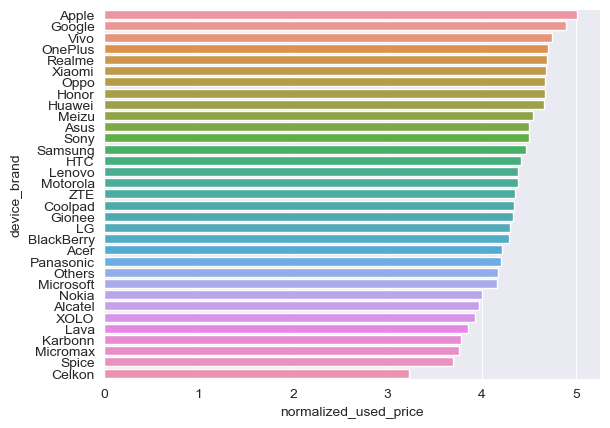

In [71]:
# Barplot showing which device is associated with the highest used price
frame = df.groupby('device_brand').mean('normalized_used_price')['normalized_used_price'].sort_values(ascending=False)
sns.barplot(frame, frame.index)

C:\Users\ituser\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='days_used', ylabel='normalized_used_price'>

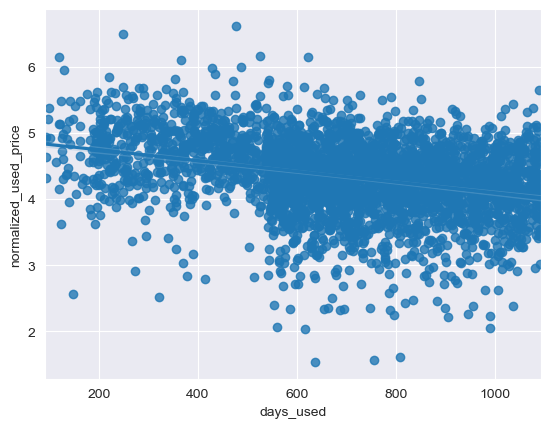

In [72]:
sns.regplot(df['days_used'], df['normalized_used_price'])

Normalized used price decreases as the days_used increases according to the regplot above

In [73]:
# Showing correlation between days_used and normalized_used_price
df['days_used'].corr(df['normalized_used_price'])

-0.32929456949425673

In [74]:
# Showing correlation coefficient for each of the variables with the target 'normalized_used_price'
corr_matrix = df.corr()
print(corr_matrix['normalized_used_price'])

screen_size              0.607894
4g                       0.545212
5g                       0.257980
rear_camera_mp           0.584352
front_camera_mp          0.589587
internal_memory          0.151847
ram                      0.488110
battery                  0.608978
weight                   0.387299
release_year             0.502589
days_used               -0.329295
normalized_used_price    1.000000
normalized_new_price     0.831505
Name: normalized_used_price, dtype: float64


Quite a number of variables here have a pretty high correlation with the normalized used price.

C:\Users\ituser\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='normalized_used_price', ylabel='release_year'>

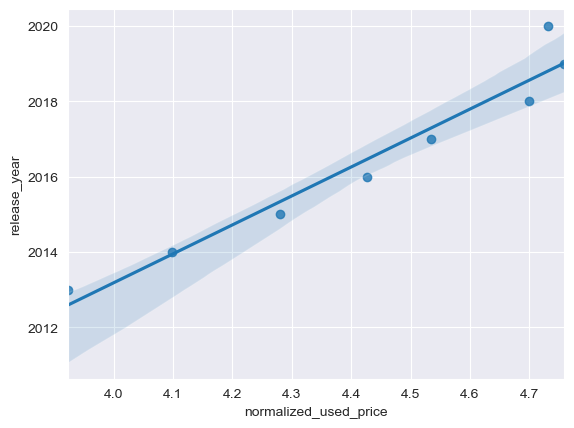

In [86]:
# Plot of average resale price for each year
frame = df.groupby('release_year').mean('normalized_used_price')['normalized_used_price']
#frame
sns.regplot(frame, frame.index)

Its easy to see that the normalized used price increases as the release year increases. So the average phone resale value does not decrease in recent years, it actually increases. Possibly because phones are improving at a quick rate and so is the cost of making them.

<h3>Analysis - CHI 2 TEST</h3>

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3255 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_brand           3255 non-null   object 
 1   os                     3255 non-null   object 
 2   screen_size            3255 non-null   float64
 3   4g                     3255 non-null   int64  
 4   5g                     3255 non-null   int64  
 5   rear_camera_mp         3255 non-null   float64
 6   front_camera_mp        3255 non-null   float64
 7   internal_memory        3255 non-null   float64
 8   ram                    3255 non-null   float64
 9   battery                3255 non-null   float64
 10  weight                 3255 non-null   float64
 11  release_year           3255 non-null   int64  
 12  days_used              3255 non-null   int64  
 13  normalized_used_price  3255 non-null   float64
 14  normalized_new_price   3255 non-null   float64
dtypes: f

In [101]:
chi2(df[['4g']], df[['os']])

(array([48.2550753]), array([1.87927639e-10]))

In [114]:
np.sqrt((48.2550753/len(df))/(np.min((len(df.columns)-1, len(df)-1))))

0.03254108164664133

In [103]:
chi2(df[['release_year']], df[['device_brand']])

(array([1.86806741]), array([1.]))

In [104]:
chi2(df[['5g']], df[['device_brand']])

(array([192.27227909]), array([8.87395198e-25]))

<h3>Analysis - Cramer's V</h3>

In [75]:
df

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,1,0,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,1,1,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,1,1,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,1,1,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,1,0,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3447,Apple,iOS,15.27,1,0,8.0,7.0,64.0,4.0,3110.0,194.0,2019,208,5.100902,6.287933
3450,Asus,Android,15.24,1,0,13.0,8.0,128.0,8.0,4000.0,200.0,2018,541,5.037732,6.251538
3451,Alcatel,Android,15.80,1,0,13.0,5.0,32.0,3.0,4000.0,165.0,2020,201,4.357350,4.528829
3452,Alcatel,Android,15.80,1,0,13.0,5.0,32.0,2.0,4000.0,160.0,2020,149,4.349762,4.624188


In [77]:
df.to_csv('../data/sales_clean.csv')